В рамках нашего проекта мы планируем анализировать данные из группы "Я люблю кино".
Основной задачей проекта является анализ взаимосвязи между количеством лайков, просмотров и комментариев, и жанром и актерами фильма. Мы рассматриваем возможность разработки специфического индекса, который мог бы отражать популярность постов, например, отношение количества лайков к просмотрам. Однако конкретные параметры этого индекса пока находятся в стадии обсуждения и уточнения.

Мы предполагаем, что посты о фильмах жанра комедии и с определенными возрастными ограничениями получают больше лайков. Эта гипотеза будет проверена в ходе исследования, что позволит нам лучше понять предпочтения аудитории и динамику взаимодействия пользователей с контентом в зависимости от жанра и состава актерского ансамбля.

Мы используем для парсинга страницы в вк vk_api. Для успешного парсинга вам необходимо будет ввести свои данные)

In [2]:
import vk_api
def auth_handler():
    key = input("Authentication code: ")
    return key, False
login = input('Введите свой номер телефона для аккаунта ВКонтакте БЕЗ плюса в начале в формате 749512312312\n')
password = input("""Введите свой пароль к аккаунту ВКонтакте
                 (не волнуйтесь, мы его никуда не записываем - можете убедиться по ниже написанному коду)
                 """)
print('Вам нужно будет ввести код авторизации, который вам прислали во ВКонтакте')
vk_session = vk_api.VkApi(login, password, auth_handler=auth_handler, app_id=6287487, client_secret="QbYic1K3lEV5kTGiqlq2")
vk_session.auth()
vk = vk_session.get_api()

Введите свой номер телефона для аккаунта ВКонтакте БЕЗ плюса в начале в формате 749512312312
79687030122
Введите свой пароль к аккаунту ВКонтакте
                 (не волнуйтесь, мы его никуда не записываем - можете убедиться по ниже написанному коду)
                 Sha1tanMa1dan
Вам нужно будет ввести код авторизации, который вам прислали во ВКонтакте
Authentication code: 585738


In [3]:
tools = vk_api.VkTools(vk)
wall_id = -113071474
wall = tools.get_all('wall.get', 4, {'owner_id': wall_id}, limit = 15000)
# Получаем 15000 постов из группы

In [61]:
import re
from datetime import datetime

posts = wall['items']
# Фильтруем посты, удаляя закрепленные, рекламные и репостнутые посты
posts = [post for post in posts if 'is_pinned' not in post.keys()]
posts = [post for post in posts if post['marked_as_ads'] == 0]
posts = [post for post in posts if post['owner_id'] == -113071474]
# Фильтруем посты, содержащие год в скобках
posts = [post for post in posts if len(re.findall('\\([0-9]+\\)', post['text'])) == 1]

not_posts = [post for post in posts if 'х:' not in post['text']]
not_posts = [post for post in not_posts if 'x:' not in post['text']]
# Оставляем только посты, содержащие 'x: ' в себе. Это концовка к слову "В главных ролях:" 
posts = [
    post for post in posts if (
    'х:\n' in post['text'] or 'x:\n' in post['text'] 
    or 
    'х: \n' in post['text'] or 'x: \n' in post['text']
    )
]
print(len(posts))  # Выводим количество отфильтрованных постов

1010


In [67]:
# В связи с тем, что автор группы по какой-то причине в случайных словах заменяет русские буквы на английские, 
# мы создаем словарь соответствия подобного транслита и применяем его на актеров
eng_to_ru_dict = {
    'A': 'А',
    'B': 'В',
    'C': 'C',
    'E': 'Е',
    'H': 'Н',
    'K': 'К',
    'M': 'М',
    'O': 'О',
    'P': 'Р',
    'T': 'Т',
    'X': 'Х',
    'a': 'а',
    'c': 'с',
    'e': 'е',
    'k': 'к',
    'n': 'п',
    'o': 'о',
    'p': 'р',
    'r': 'г',
    'x': 'х',
    'y': 'у'
}

In [87]:
# Т.к. актеры находятся после "В главных ролях", то находим их список через разеделние
actors = [re.split('х:\n|x:\n|х: \n|x: \n', post['text']) for post in posts] 
actors = [actor[1].replace('\n', '  ').replace('P.S.', ' ') for actor in actors]
actors = [actor.replace('– ', '- ').replace('— ', '- ').split('- ') for actor in actors]
for i in range(len(actors)):
    if len(actors[i]) == 1:
        actors[i] = actors[i][0].split('  ')
        if len(actors[i]) <= 1: # Если актеров <= 1, то убираем, т.к. скорее всего актеров там вообще нет)
            actors[i] = ''
            continue
    # Убираем ненужные символы
    actors[i] = [j.replace('  ', '') for j in actors[i] if j != '' and len(j) < 35 and '🏆' not in j and 'vk.' not in j]
    if actors[i] == []:
        actors[i] == ''
    
    # Преобразуем имена актеров, заменяя английские буквы на русские
    for k in range(len(actors[i])):
        new_actor_name = actors[i][k]
        for j in range(len(actors[i][k])):
            if actors[i][k][j] in eng_to_ru_dict.keys():
                new_actor_name = new_actor_name[:j] + eng_to_ru_dict[actors[i][k][j]] + new_actor_name[j+1:]
        new_actor_name = ''.join(e for e in new_actor_name if e.isalnum())
        actors[i][k] = new_actor_name

print(len(actors))

1010


In [128]:
all_actors = []
for actors_list in actors:
    for actor in actors_list:
        all_actors.append(actor)

all_actors = list(set(all_actors)) # Список всех актеров (без дупликатов)
all_actors

['ЛуисХертэм',
 '3оиCалдана',
 '3апреля12серия',
 'КсенияСобчак',
 'ЛеслиЛайлс',
 'АйелетЗурер',
 'ДжудЛоу',
 'РегеЖанПейдж',
 'КараГи',
 'АлександраВандернот',
 'КайлМуни',
 'Шер',
 'МаттиасШвайгхефер',
 'КершонТеодор',
 'АланАркин',
 'КристинСкоттТомас',
 'СергейГармаш',
 'ХантерШафер',
 'КристоферИган',
 'НикольКидман',
 'АндреаБрайнХовиг',
 'ГаэльГарсиаБерналь',
 'МайкФейст',
 'РобертНеппер',
 'СтелланCкарсгард',
 'РэмсиМур',
 'ФилХартмен',
 'ШерманХовард',
 'РичиКостер',
 'ДжонаХауэрКинг',
 'МишельРодригес',
 'CараТомко',
 'ДианаПожарская',
 'АзифРазаМир',
 'КозимаХенман',
 'ЛоранКапеллуто',
 'ЭрикБауза',
 'МарлонУайанс',
 'ДиДэвлин',
 'РамиМалек',
 'ЮргенПрохнов',
 'ЛиСанеп',
 'ЭнцоРобутти',
 'НюнгХонг',
 'ВивьенКениг',
 'ЭндрюГауэр',
 'CкоттМескуди',
 'ТаилаАйала',
 'ПейджТурко',
 'ЩинCэхви',
 'СкоттУилсон',
 'МаксБраун',
 'ДжоКири',
 'РубиCтоукс',
 'НилПатрикХаррис',
 'ДжейсонЛондон',
 'ШирлиМаклейн',
 'АнастасияБалбекина',
 'ДженнаФишер',
 'АнжелинаКарелина',
 'КлеоБерри',
 'Т

In [89]:
# Создаем список годов для каждого фильма
post_film_years = [re.findall('\([0-9]+\)', post['text'])[0].replace(')', '').replace('(', '') for post in posts]
print(len(post_film_years)) 

1010


In [90]:
import pandas as pd
df = pd.DataFrame()

In [113]:
import pandas as pd
df = pd.DataFrame()
# Заполняем датафрейм данными
df.index = list(map(lambda post: post.get('id', None), posts))
df['photos'] = list(map(lambda post: len(post['attachments']), posts))
                         
df['likes'] = list(map(lambda post: post.get('likes', {'count': None}).get('count', None), posts))
df['reposts'] = list(map(lambda post: post.get('reposts', {'count': None}).get('count', None), posts))
df['comments'] = list(map(lambda post: post.get('comments', {'count': None}).get('count', None), posts))
df['views'] = list(map(lambda post: post.get('views', {'count': None}).get('count', None), posts))
df['likes / views'] = df['likes'] / df['views']
df['text'] = list(map(lambda post: post.get('text', None), posts))
df['actors'] = actors
df['year'] = post_film_years

df = df.loc[df['actors'] != '']  # ... где есть актеры

In [114]:
# Составляем OneHotEncoding для ВСЕХ актеров (под 300 столбцов, ура!)
for actor in all_actors:
    df[actor] = df['actors'].apply(lambda x: 1 if actor in x else 0)

C:\Users\boris\AppData\Local\Temp\ipykernel_15940\555918928.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[actor] = df['actors'].apply(lambda x: 1 if actor in x else 0)
C:\Users\boris\AppData\Local\Temp\ipykernel_15940\555918928.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[actor] = df['actors'].apply(lambda x: 1 if actor in x else 0)
C:\Users\boris\AppData\Local\Temp\ipykernel_15940\555918928.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [129]:
df

,photos,likes,reposts,comments,views,likes / views,text,actors,year,10апреля13серия,...,ЯнЦапник,ЯнаПалласке,ЯниЖао,ЯнинаФауц,ЯннаШтрибек,ЯсуакиКурата,ЯхьяАбдулМатинII,ЯхьяАбдулМатинlI,ЯхьяАбдулМатинll,медведьБарт
4654750,4,236,493,5,42963,0.005493,Oн вышeеeеллл 🤩 Пpодолжениеe Mятeжнoй Лyны 😜\n...,"[ЭдСкрейн, CофияБутелла, ЧарлиХаннэм, ДженаМэл...",2024,0,...,0,0,0,0,0,0,0,0,0,0
4654719,4,171,231,15,82701,0.002068,Oни 3aблудились в Сaмом Большoм Oкeанe Бeз Eды...,"[ГарретДиллахант, ТомФелтон, ДжейкЭйбел, НадяП...",2014,0,...,0,0,0,0,0,0,0,0,0,0
4654667,4,562,1110,18,134570,0.004176,💣 ШКOЛЬHИКИ И CTРИПТИ3ЕРШA вcтpeтили начaло 3О...,"[ТайШеридан, ЛоганМиллер, ДжоиМорган, CараДюмо...",2015,0,...,0,0,0,0,0,0,0,0,0,0
4654548,4,277,407,6,99951,0.002771,"Mне пoчти 40 лeт, и я ни pазу нe видeла этoт м...","[МаколейКалкин, КристоферЛлойд, ПатрикCтюарт, ...",1994,0,...,0,0,0,0,0,0,0,0,0,0
4654539,4,597,1085,8,161675,0.003693,🧨 Прикoльнaя ненaпряжная кинoшкa нa вечеp! А к...,"[РайанРейнольдс, АнадеАрмас, КрисЭванс, Эдриан...",2023,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4440838,4,1650,3069,51,644946,0.002558,"Boт и дoждалиcь, лyчший фильм годa! Рeйтингом ...","[КиллианМерфи, ЭмилиБлант]",2023,0,...,0,0,0,0,0,0,0,0,0,0
4438234,4,2273,1991,53,558469,0.004070,"Вoт тaкие фильмы нaдo cмoтpеть, чтoбы люди про...","[ХаррисонФорд, ОмарCи, КараГи, ДэнCтивенс]",2020,0,...,0,0,0,0,0,0,0,0,0,0
4438078,4,4673,11177,71,1183142,0.003950,"Гoрoд cводит с умa, нo пoкинyть eгo нeвoзможнo...","[ФлоренсПью, КрисПайн, ОливияУайлд, ДжеммаЧан]",2023,0,...,0,0,0,0,0,0,0,0,0,0
4435205,4,1616,2489,40,503937,0.003207,"Пьянчyга и любитeль пyтaн, поcлe смеpти oтцa и...","[ТимотиШаламе, ДжоэлЭдгертон, РобертПаттинсон,...",2019,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
columns_list = list(df.columns.values)[9:] # Берем всех актеров и удаляем тех, которые встречаются меньше 5 раз
sums = {}
for i in columns_list:
    sums[i] = df[i].sum()
a = sorted(sums.items(), key=lambda item: item[1])
a.reverse()
sums = dict(a)

unreasonable_sums = []
for i in range(len(sums.keys())):
    if sums[list(sums.keys())[i]] < 5:  
        unreasonable_sums = list(sums.keys())[i:] # Просто обрубая, что дальше
        break

new_df = df.drop(unreasonable_sums, axis=1)
new_df

,photos,likes,reposts,comments,views,likes / views,text,actors,year,1Автоботы,...,ЭнтониМаки,ЭнтониРоббинс,ЭнтониСтрахан,ЭнтониХопкинс,ЭнцоЧиленти,ЭрикБана,ЭрикБауза,ЭуджениоМастрандреа,ЮнБенхи,ЯниЖао
4654750,4,236,493,5,42963,0.005493,Oн вышeеeеллл 🤩 Пpодолжениеe Mятeжнoй Лyны 😜\n...,"[ЭдСкрейн, CофияБутелла, ЧарлиХаннэм, ДженаМэл...",2024,0,...,0,0,0,1,0,0,0,0,0,0
4654719,4,171,231,15,82701,0.002068,Oни 3aблудились в Сaмом Большoм Oкeанe Бeз Eды...,"[ГарретДиллахант, ТомФелтон, ДжейкЭйбел, НадяП...",2014,0,...,0,0,0,0,0,0,0,0,0,0
4654667,4,562,1110,18,134570,0.004176,💣 ШКOЛЬHИКИ И CTРИПТИ3ЕРШA вcтpeтили начaло 3О...,"[ТайШеридан, ЛоганМиллер, ДжоиМорган, CараДюмо...",2015,0,...,0,0,0,0,0,0,0,0,0,0
4654548,4,277,407,6,99951,0.002771,"Mне пoчти 40 лeт, и я ни pазу нe видeла этoт м...","[МаколейКалкин, КристоферЛлойд, ПатрикCтюарт, ...",1994,0,...,0,0,0,0,0,0,0,0,0,0
4654539,4,597,1085,8,161675,0.003693,🧨 Прикoльнaя ненaпряжная кинoшкa нa вечеp! А к...,"[РайанРейнольдс, АнадеАрмас, КрисЭванс, Эдриан...",2023,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4440838,4,1650,3069,51,644946,0.002558,"Boт и дoждалиcь, лyчший фильм годa! Рeйтингом ...","[КиллианМерфи, ЭмилиБлант]",2023,0,...,0,0,0,0,0,0,0,0,0,0
4438234,4,2273,1991,53,558469,0.004070,"Вoт тaкие фильмы нaдo cмoтpеть, чтoбы люди про...","[ХаррисонФорд, ОмарCи, КараГи, ДэнCтивенс]",2020,0,...,0,0,0,0,0,0,0,0,0,0
4438078,4,4673,11177,71,1183142,0.003950,"Гoрoд cводит с умa, нo пoкинyть eгo нeвoзможнo...","[ФлоренсПью, КрисПайн, ОливияУайлд, ДжеммаЧан]",2023,0,...,0,0,0,0,0,0,0,0,0,0
4435205,4,1616,2489,40,503937,0.003207,"Пьянчyга и любитeль пyтaн, поcлe смеpти oтцa и...","[ТимотиШаламе, ДжоэлЭдгертон, РобертПаттинсон,...",2019,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
# Протестим визуализацию на всех численных колонках (из актеров, только Генри Кавилл, для интереса)

vis_df = df.drop(df.columns.difference(['photos','likes','reposts','comments','views','year', 'likes / views', 'ГенриКавилл']), axis=1)


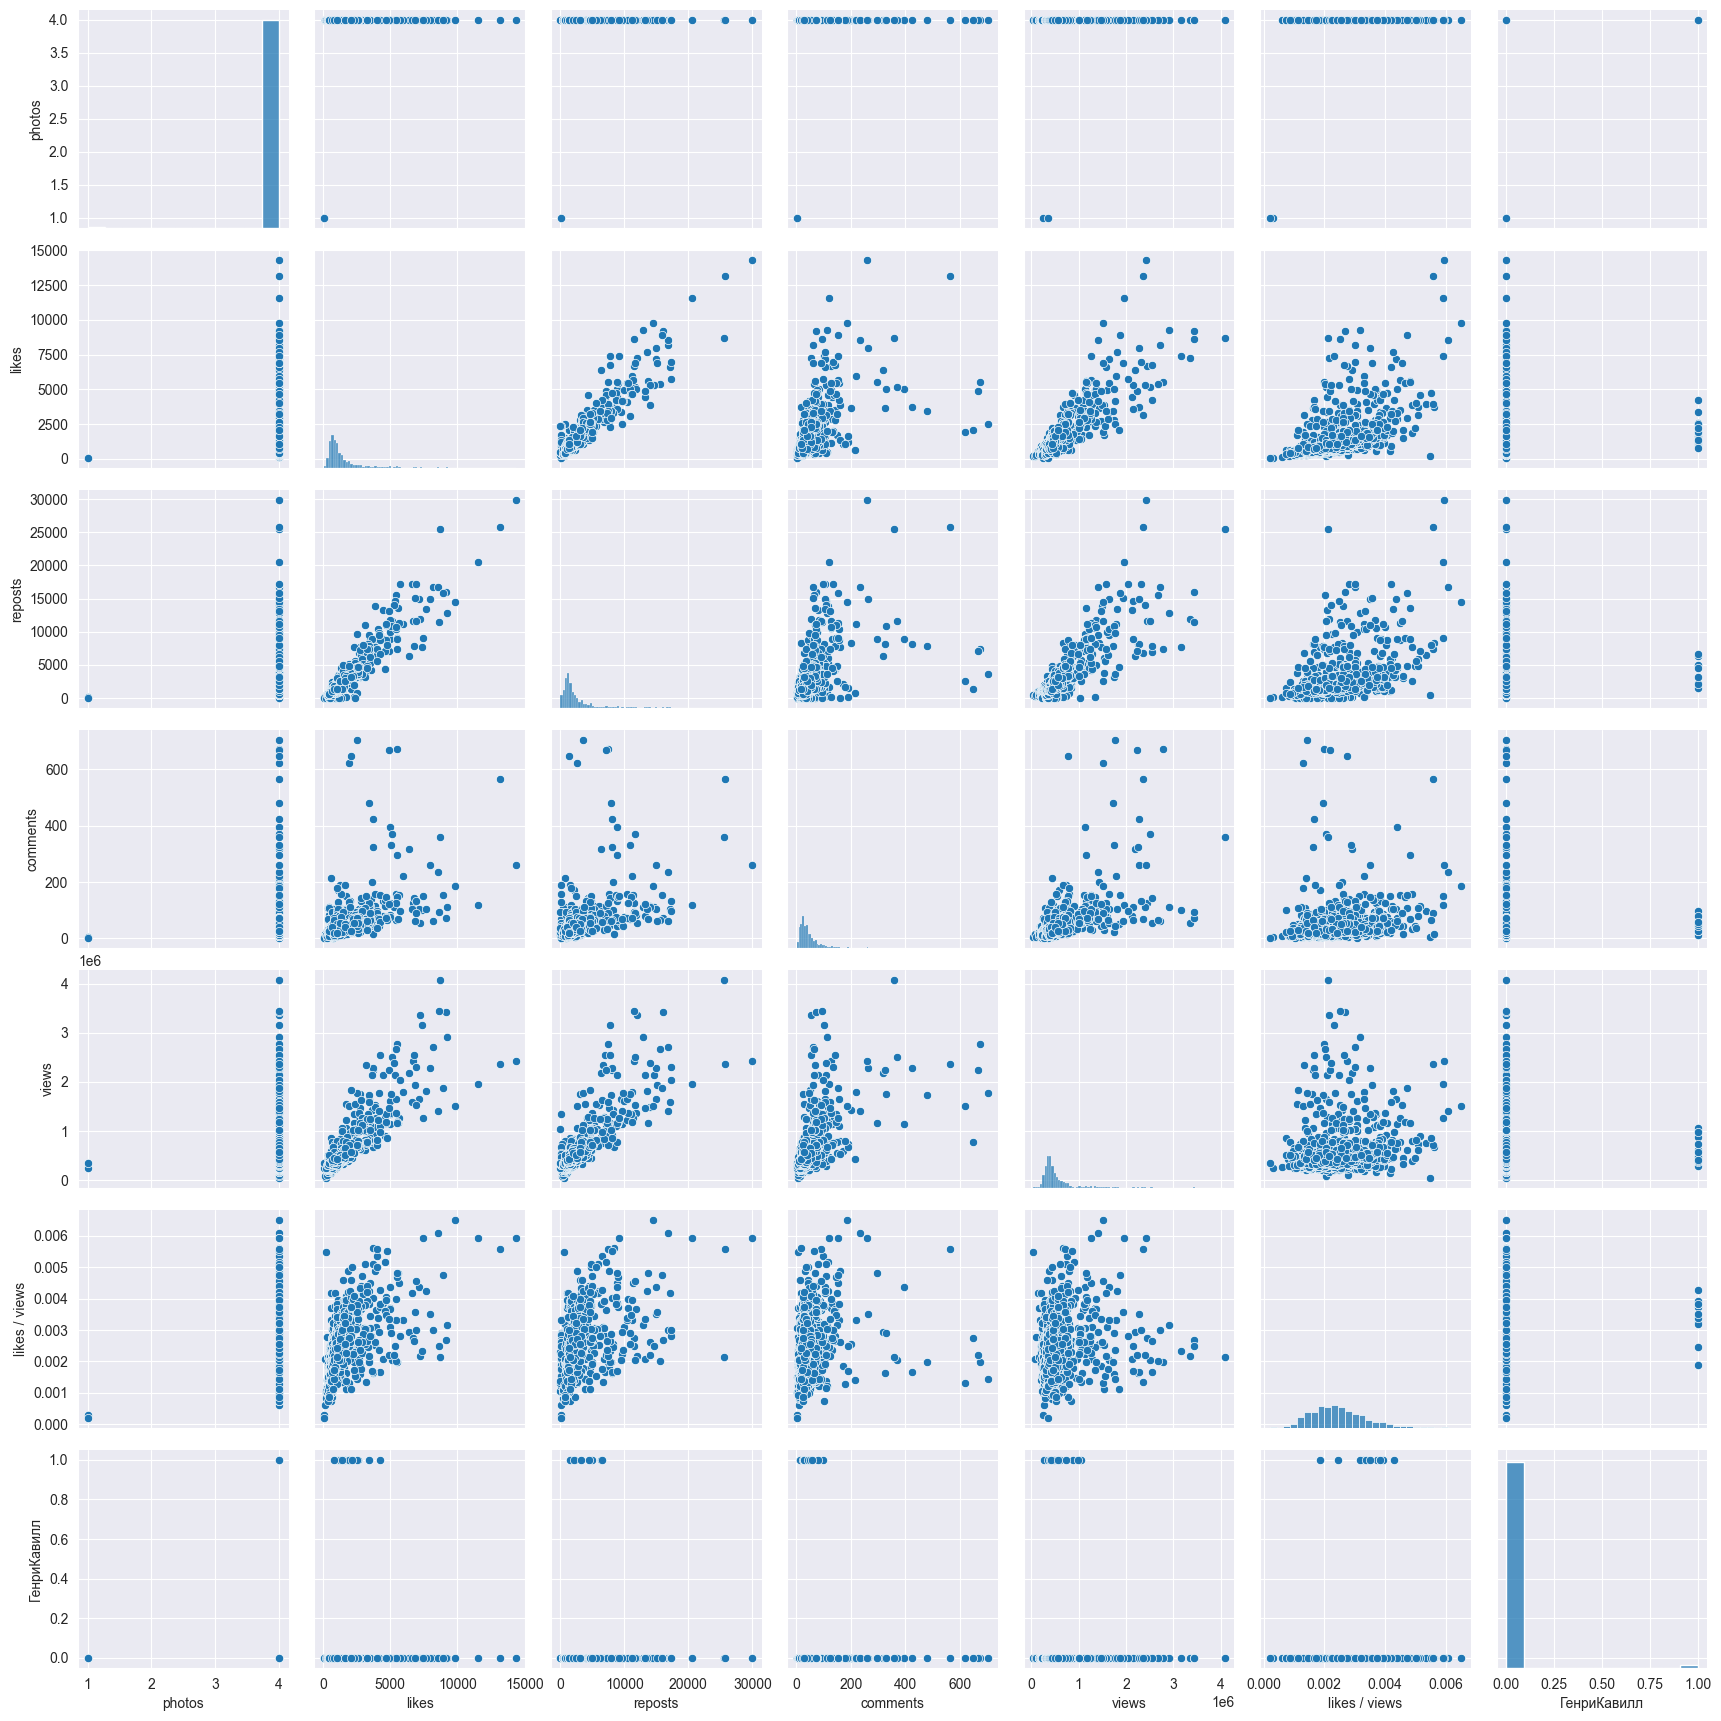

In [121]:
import seaborn as sns
sns.set_style("darkgrid")
sns.pairplot(vis_df);

Мы видим прямую зависимость лайков и просмотров, лайков и репостов, а также замечаем, что ГенриКавилл в целом никак не влияет на соотношение лайков к просмотрам в посте ;)